This will be for the sorption system. This streamlines the process of extracting usable data from the raw data.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


To use:

1.   Need to upload the raw data from sorption system to Pascal Drive
2.   Need to modify "report.csv" manually since pandas isn't smart enough. Use  
         ctrl + f to replace all "," with "". Should be 5 replacements if 1 temp test. Upload this new report to the drive
3.   Need to change file path names for "data.csv" and "report.csv"
4.   Change the mass of sample, temp of run (to one decimal since used for name
         searching later), name of sample, working gas
5.   This script can do only one test temp at a time, similar to the Excel  
     sheet has one sheet per temp.
6.   Should run in ~5s.
7.   Happy sorption!



Once deleted, variables cannot be recovered. Proceed (y/[n])? y


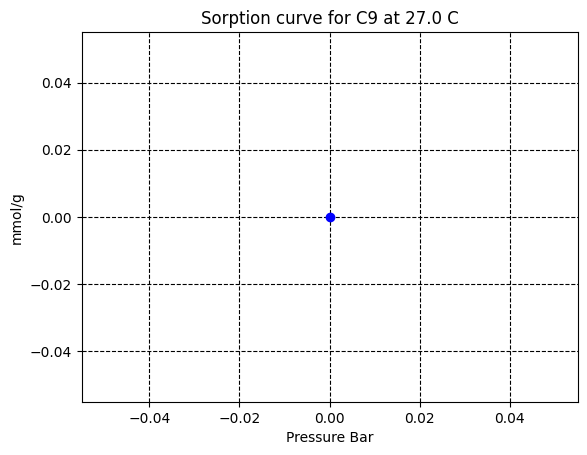

The density of the sample is nan g/cm^3
The code has finished running


In [ ]:
from re import M
%reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statistics as st

# See PyCharm help at https://www.jetbrains.com/help/pycharm/

#Things the user must input
#This script can only find curves for one temp, so need to change here for more runs (basically one sheet)
#This has to match the same syntax as the report.csv
mass_sample = 0.5960 #g
T_run_C = 27.0 #C
name_compound = "C9"
working_gas = "CO2"
T_run_K = T_run_C + 273.15 #K

#Loading the data
data = pd.read_csv('/content/gdrive/Shareddrives/Pascal/Technology/Chemistry/Jinyoung/archive/Sharon/Experimental Documentation/Sorption/Raw Data/241216-1419-241216 C9-powder 27C/data.csv')

#Loading the report, need to get rid of all commas inside the csv file for this version
report = pd.read_csv('/content/gdrive/Shareddrives/Pascal/Technology/Chemistry/Jinyoung/archive/Sharon/Experimental Documentation/Sorption/Raw Data/241216-1419-241216 C9-powder 27C/report3.csv', quotechar="'", encoding='latin-1')

#Parameters that I keep between experiments

#Density sheet
#Chamber volume
v_c_small = 9.141 #cm^3, I think there is a typo in the Excel sheet
v_c_large = 9.446 #cm^3, not used in density calculation but later

#Virial Constants for N2
a_N2 = 185.4 #cm^3/mol
b_N2 = 141.8 #cm^3/mol
c_N2 = 88.7 #K

#Gas Constant
R = 1205.9 #psi*cm^3/K*mol

#Temperature
T_C_N2 = 25 #C
T_K_N2 = T_C_N2+273.15 #K

#Second Virial Coefficient
B_N2 = a_N2 - b_N2 * np.exp(c_N2/T_K_N2) #cm^3/mol


#Now calculating the density sheet
N2_initial = np.zeros(3)
N2_final = np.zeros(3)
vacuum_N2_start = np.zeros(3)
vacuum_N2_raw = np.zeros(3)
vacuum_N2_zeroed_initial = np.zeros(3)
vacuum_N2_zeroed_final = np.zeros(3)
PRT_initial = np.zeros(3)
PRT_final = np.zeros(3)
M_vol_initial = np.zeros(3)
M_vol_final = np.zeros(3)
M_vol_ratio = np.zeros(3)
gas_vol = np.zeros(3)
gas_vol_real = 0; #cm^3
v_sample_holder = 3.59281546300944 #cm^3, this comes from calibration experiments


#This is the key labels we need to search for
s1 = 'Sequence 1: N2 at 25.0 °C'
s2 = 'Sequence 2: N2 at 25.0 °C'
s3 = 'Sequence 3: N2 at 25.0 °C'

#This will look through the report labels
for i in range(len(report)):
    #These are finding the initial and final N2 pressures
    if report.iloc[i,0]==s1:
        N2_initial[0] = report.iloc[i+8,1]
        N2_final[0] = report.iloc[i+9,1]
        vacuum_N2_start[0] = (report.iloc[i+3,1])
    elif report.iloc[i,0]==s2:
        N2_initial[1] = report.iloc[i+8,1]
        N2_final[1] = report.iloc[i+9,1]
        vacuum_N2_start[1] = (report.iloc[i + 3, 1])
    elif report.iloc[i,0]==s3:
        N2_initial[2] = report.iloc[i+8,1]
        N2_final[2] = report.iloc[i+9,1]
        vacuum_N2_start[2] = (report.iloc[i + 3, 1])

vacuum_N2_start = np.floor(vacuum_N2_start)

#Here is finding the raw vacuum data
for i in range(len(vacuum_N2_raw)):
    #This is the orange vacuum pressures for zeroing
    vacuum_N2_start[i] = int(vacuum_N2_start[i])
    vacuum_N2_raw[i] = np.mean(data.iloc[(int(vacuum_N2_start[i])-100):int(vacuum_N2_start[i]),2])

    #This is doing the zeroing
    vacuum_N2_zeroed_initial[i] = N2_initial[i] - vacuum_N2_raw[i]
    vacuum_N2_zeroed_final[i] = N2_final[i] - vacuum_N2_raw[i]

    #This is doing some P/RT calculations
    PRT_initial[i] = vacuum_N2_zeroed_initial[i]/(R*T_K_N2)
    PRT_final[i] = vacuum_N2_zeroed_final[i] / (R * T_K_N2)

    #This is doing molar volume calculations
    M_vol_initial[i] = (1 + np.sqrt(1 - 4 * PRT_initial[i] * (-B_N2))) / (2 * PRT_initial[i])
    M_vol_final[i] = (1 + np.sqrt(1 - 4 * PRT_final[i] * (-B_N2))) / (2 * PRT_final[i])
    M_vol_ratio[i] = M_vol_final[i] / M_vol_initial[i] - 1

    #This is calculating sample volume
    gas_vol[i] = v_c_small * M_vol_ratio[i]
#THIS MIGHT BE AN ERROR, SEEMS TO BE OFF BY 0.001 CM^3


gas_vol_real = np.mean(gas_vol)
v_sample = v_sample_holder - gas_vol_real #cm^3
density_sample = mass_sample / v_sample #g/cm^3




#Now calculating the sorption and desorption curve at a specific temp
[r,c]=report.shape

#This is for finding background vacuum pressure
#This is the key labels we need to search for
s5 = 'Sequence 5: ' + working_gas + ' at ' + str(T_run_C) +' °C'

#These are parameters
run_start = 0 #This is when the CO2 or C3H8 gets injected
run_raw_background_high_P = np.zeros(300)
run_raw_background_low_P = np.zeros(300)

#These are the things the person will copy over
run_initial = np.zeros(c*3).reshape(c,3)
run_final = np.zeros(c*3).reshape(c,3)
run_post = np.zeros((c+1)*3).reshape(c+1,3)
v_charge = np.zeros(c)
p_vac = np.zeros(c)
n_tot = np.zeros(c+1)


#This will look through the report labels
for i in range(len(report)):
    #These are finding the raw background vacuum pressures
    if report.iloc[i,0]==s5:
        run_start = np.floor(int((report.iloc[i+3,1])))
        run_raw_background_high_P = data.iloc[(int(run_start) - 300):int(run_start), 1]
        run_raw_background_low_P = data.iloc[(int(run_start) - 300):int(run_start), 2]

# THIS IS PULLING THE DATA WEIRDLY, COULD BE AN ERROR
        run_initial[0:-1,0] = report.iloc[i + 8, 1:c]
        run_final[0:-1,0] = report.iloc[i + 9, 1:c]
        run_post[1:-1,0] = report.iloc[i + 10, 1:c+1]
        v_charge[0:-1] = report.iloc[i + 13, 1:c]

#This finds the backgound pressure in vacuum before the run
run_vacuum_background_low = np.mean(run_raw_background_low_P)
run_vacuum_background_high = np.mean(run_raw_background_high_P)

#Parameters for temperature sheets
v_v = 0.02252 #cm^3
B_star = (1.0971 * 10**2 - 8.4673 * 10**4 / T_run_K - 8.1215 * 10**6 / (T_run_K**2)
      - 3.482 * 10**9 / (T_run_K**3)) / (8.314 * 10**6 * T_run_K)

#This is finding the right charge volume and pressure vac
for i in range(len(v_charge)):
    if v_charge[i] == v_c_small:
        p_vac[i] = run_vacuum_background_low * 6894.76
    elif v_charge[i] == v_c_large:
        p_vac[i] = run_vacuum_background_high * 6894.76

#This adds the P_post initial conditions
run_post[0] = run_vacuum_background_low

#Now we have to calculate the other terms in the pressure stuff
for i in range(len(run_initial)):
    run_initial[i,1] = run_initial[i,0] * 6894.76
    run_initial[i,2] = 1 + B_star * (run_initial[i,1]-p_vac[i])

for i in range(len(run_final)):
    run_final[i,1] = run_final[i,0] * 6894.76
    run_final[i,2] = 1 + B_star * (run_final[i,1]-p_vac[i])

for i in range(len(run_post)):
    run_post[i,1] = run_post[i,0] * 6894.76
    run_post[i,2] = 1 + B_star * (run_post[i,1]-p_vac[i-1])

#Now find n_tot
#This calculates the total moles absorbed - note it is off from the Excel sheet since v_c was wrong in the sheet I think
for i in range(len(n_tot)-1):
    n_tot[i+1] = (n_tot[i] + \
                 (run_initial[i,1]-p_vac[i]) * v_charge[i] / (run_initial[i,2] * 8.314 * 10**6 * T_run_K) \
                  + ((run_final[i-1,1] - p_vac[i]) * (v_charge[i-1] + v_sample_holder + v_v - v_sample) / run_final[i-1,2] \
                        - (run_post[i,1] - p_vac[i]) * v_charge[i-1] / run_post[i,2]) / (8.314*10**6 * T_run_K) \
                            - (run_final[i,1] - p_vac[i]) * (v_charge[i] + v_sample_holder + v_v - v_sample) / (run_final[i,2] * 8.314*10**6 * T_run_K))

#Calculate the rest of the sheet columns
p_bar = np.zeros(c)
for i in range(len(p_bar)-1):
    p_bar[i+1] = run_final[i,1] / 100000

C_STP = n_tot * 22.4 *1000 / v_sample #cm^3 (STP) /cm^3
C_mmol = n_tot[0:-1] * 1000 / mass_sample




#Now plotting the data
plt.plot(p_bar, C_mmol,'bo-')
plt.xlabel("Pressure Bar")
plt.ylabel("mmol/g")
plt.title("Sorption curve for " + str(name_compound) + " at " + str(T_run_C) + " C")
plt.grid(visible=True, which='major', color='k', linestyle='--')
plt.grid(visible=True, which='minor', color='k', linestyle='--')
plt.show()


print("The density of the sample is " + str(density_sample) + " g/cm^3")
print("The code has finished running")
